In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from LearningAlgorithms import ClassificationAlgorithms
import seaborn as sns
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

--------------------------------------------------------------
# Create a training and test set
--------------------------------------------------------------

In [3]:
df = pd.read_pickle('../../data/interim/03_data_features.pkl')

In [4]:
df_train = df.drop(['participant', 'category', 'set'], axis = 1)

In [5]:
X = df_train.drop('label', axis=1)
y = df_train['label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)

--------------------------------------------------------------
# Split feature subsets
--------------------------------------------------------------

In [6]:
basic_features = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
square_features = ['acc_r', 'gyr_r']

pca_features = ['pca_1', 'pca_2', 'pca_3']

time_features = [f for f in df_train.columns if '_temp_' in f]
frequency_features = [f for f in df_train.columns if ('_freq' in f) or ('_pse' in f)]

cluster_features = ['cluster']

In [7]:
print(len(basic_features), len(square_features), len(pca_features), len(time_features), len(frequency_features), len(cluster_features))

6 2 3 16 88 1


In [8]:
feature_set_1 = basic_features
feature_set_2 = list(set(basic_features + square_features + pca_features))
feature_set_3 = list(set(feature_set_2 + time_features))
feature_set_4 = list(set(feature_set_3 + frequency_features + cluster_features))

--------------------------------------------------------------
# Perform forward feature selection using simple decision tree
--------------------------------------------------------------

In [9]:
learner = ClassificationAlgorithms()

max_features = 10
selected_features, ordered_features, ordered_scores = learner.forward_selection(max_features,X_train, y_train)

0
1
2
3
4
5
6
7
8
9


In [10]:
ordered_scores

[0.8917259211376859,
 0.9915966386554622,
 0.9990303813833226,
 0.9993535875888817,
 0.9993535875888817,
 0.9993535875888817,
 0.9993535875888817,
 0.9993535875888817,
 0.9993535875888817,
 0.9993535875888817]

In [11]:
ordered_features

['acc_z_freq_0.0_Hz_ws_14',
 'acc_x_freq_0.0_Hz_ws_14',
 'duration',
 'acc_y_temp_mean_ws_5',
 'gyr_r_pse',
 'gyr_x_max_freq',
 'acc_y_pse',
 'gyr_z_freq_weighted',
 'acc_x_temp_mean_ws_5',
 'acc_r_temp_std_ws_5']

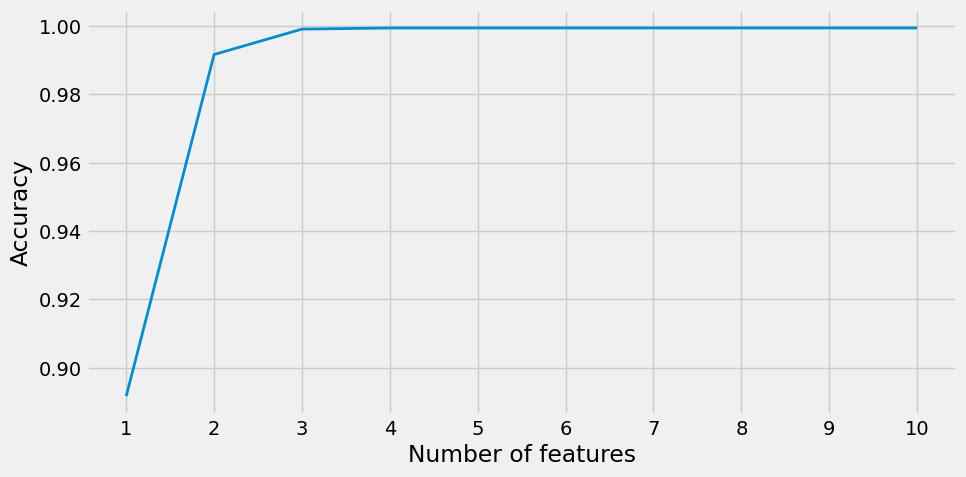

In [12]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,max_features+1,1), ordered_scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1,max_features+1,1))
plt.show()

In [13]:
selected_features = ['acc_z_freq_0.0_Hz_ws_14',
 'acc_x_freq_0.0_Hz_ws_14',
 'duration',
 'acc_y_temp_mean_ws_5',
 'gyr_r_pse',
 'gyr_x_max_freq',
 'acc_y_pse',
 'gyr_z_freq_weighted',
 'acc_x_temp_mean_ws_5',
 'acc_r_temp_std_ws_5']

--------------------------------------------------------------
# Grid search for best hyperparameters and model selection
--------------------------------------------------------------

In [16]:
possible_feature_sets = [
    feature_set_1,
    feature_set_2,
    feature_set_3,
    feature_set_4,
    selected_features
]

feature_names = [
    'Feature Set 1',
    'Feature Set 2',
    'Feature Set 3',
    'Feature Set 4',
    'Selected Features'
]

iterations = 1
score_df = pd.DataFrame()

In [17]:

for i, f in zip(range(len(possible_feature_sets)), feature_names):
    print("Feature set:", i)
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]

    # First run non deterministic classifiers to average their score.
    performance_test_nn = 0
    performance_test_rf = 0

    for it in range(0, iterations):
        print("\tTraining neural network,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.feedforward_neural_network(
            selected_train_X,
            y_train,
            selected_test_X,
            gridsearch=False,
        )
        performance_test_nn += accuracy_score(y_test, class_test_y)

        print("\tTraining random forest,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)

    performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

    performance_test_nb = accuracy_score(y_test, class_test_y)

    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                performance_test_nn,
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
            ],
        }
    )
    score_df = pd.concat([score_df, new_scores])

Feature set: 0
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 1
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 2
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 3
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 4
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes


--------------------------------------------------------------
# Create a grouped bar plot to compare the results
--------------------------------------------------------------

In [18]:
score_df.sort_values(by = 'accuracy', ascending=False)

,model,feature_set,accuracy
3,DT,Selected Features,1.000000
1,RF,Selected Features,1.000000
0,NN,Feature Set 4,0.994832
1,RF,Feature Set 4,0.993540
2,KNN,Selected Features,0.990956
0,NN,Selected Features,0.988372
1,RF,Feature Set 3,0.988372
3,DT,Feature Set 4,0.985788
0,NN,Feature Set 3,0.981912
2,KNN,Feature Set 4,0.968992


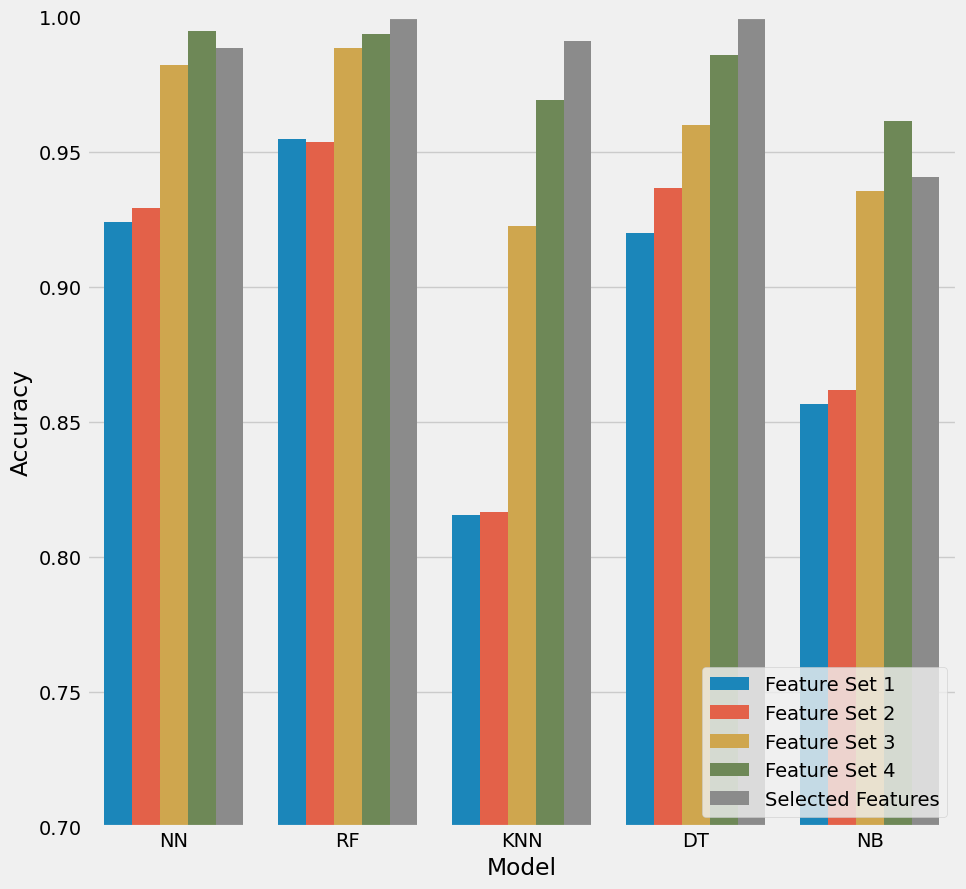

In [20]:
plt.figure(figsize=(10,10))
sns.barplot(x = 'model', y = 'accuracy', hue = 'feature_set', data = score_df)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.7,1)
plt.legend(loc = 'lower right')
plt.show()

--------------------------------------------------------------
# Select best model and evaluate results
--------------------------------------------------------------

In [21]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.random_forest(
    X_train[selected_features], y_train, X_test[selected_features], gridsearch=True
)

In [23]:
accuracy = accuracy_score(y_test, class_test_y)
accuracy

0.9987080103359173

In [24]:
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

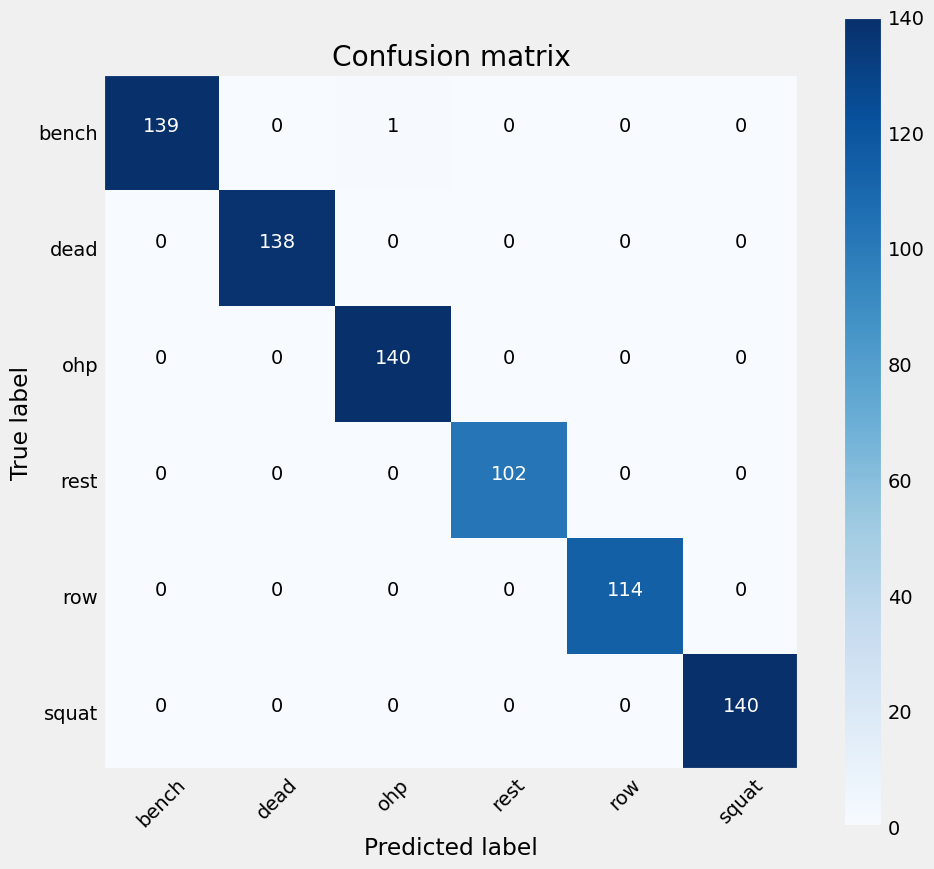

In [25]:
# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

--------------------------------------------------------------
# Select train and test data based on participant
--------------------------------------------------------------

In [26]:
participant_df = df.drop(['set', 'category'], axis=1)

X_train = participant_df[participant_df['participant'] != 'A'].drop('label', axis = 1)
y_train = participant_df[participant_df['participant'] != 'A']['label']

X_test = participant_df[participant_df['participant'] == 'A'].drop('label', axis = 1)
y_test = participant_df[participant_df['participant'] == 'A']['label']

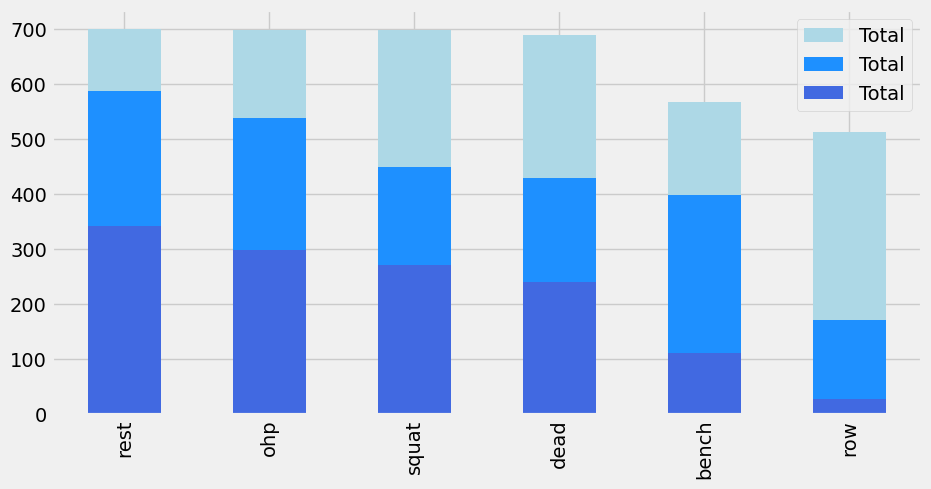

In [33]:
fig, ax = plt.subplots(figsize = (10,5))
df_train['label'].value_counts().plot(
    kind = 'bar', ax = ax, color = 'lightblue', label = 'Total'
)
y_train.value_counts().plot(
    kind = 'bar', ax = ax, color = 'dodgerblue', label = 'Total'
)
y_test.value_counts().plot(
    kind = 'bar', ax = ax, color = 'royalblue', label = 'Total'
)
plt.legend()
plt.show()

--------------------------------------------------------------
# Use best model again and evaluate results
--------------------------------------------------------------

In [34]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.random_forest(
    X_train[selected_features], y_train, X_test[selected_features], gridsearch=True
)

In [35]:
accuracy = accuracy_score(y_test, class_test_y)
accuracy

0.9690402476780186

In [36]:
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

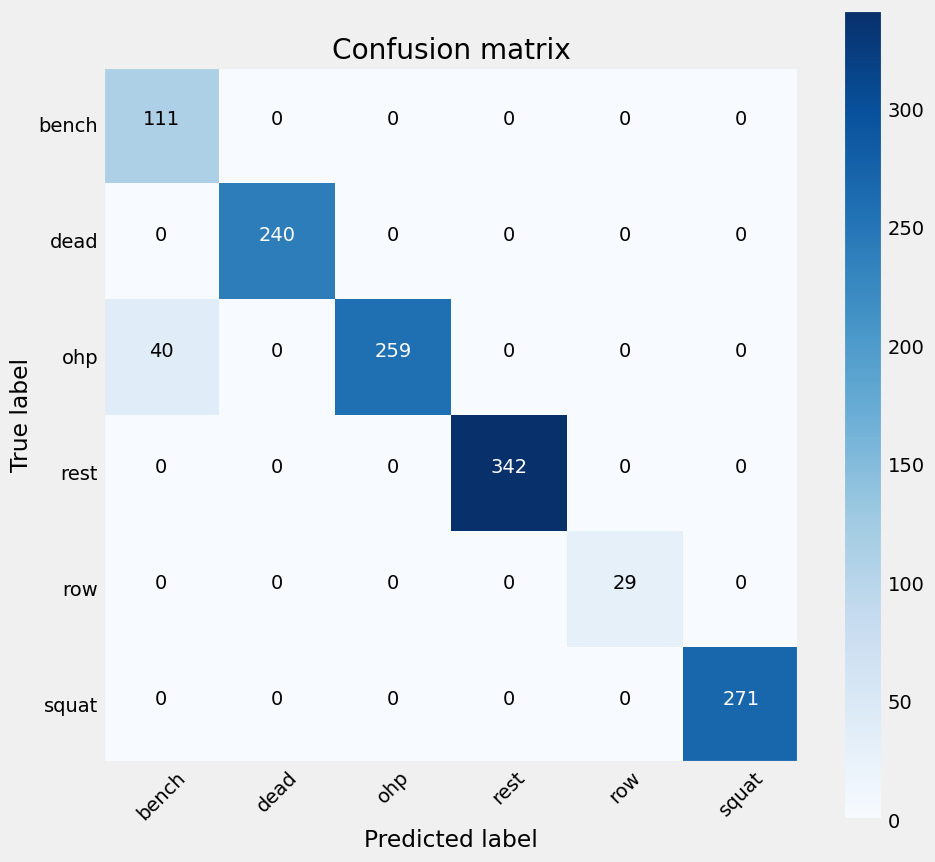

In [37]:
# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

--------------------------------------------------------------
# Using feature set 4
--------------------------------------------------------------

In [39]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.random_forest(
    X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=True
)

In [40]:
accuracy = accuracy_score(y_test, class_test_y)
accuracy

0.9953560371517027

In [41]:
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

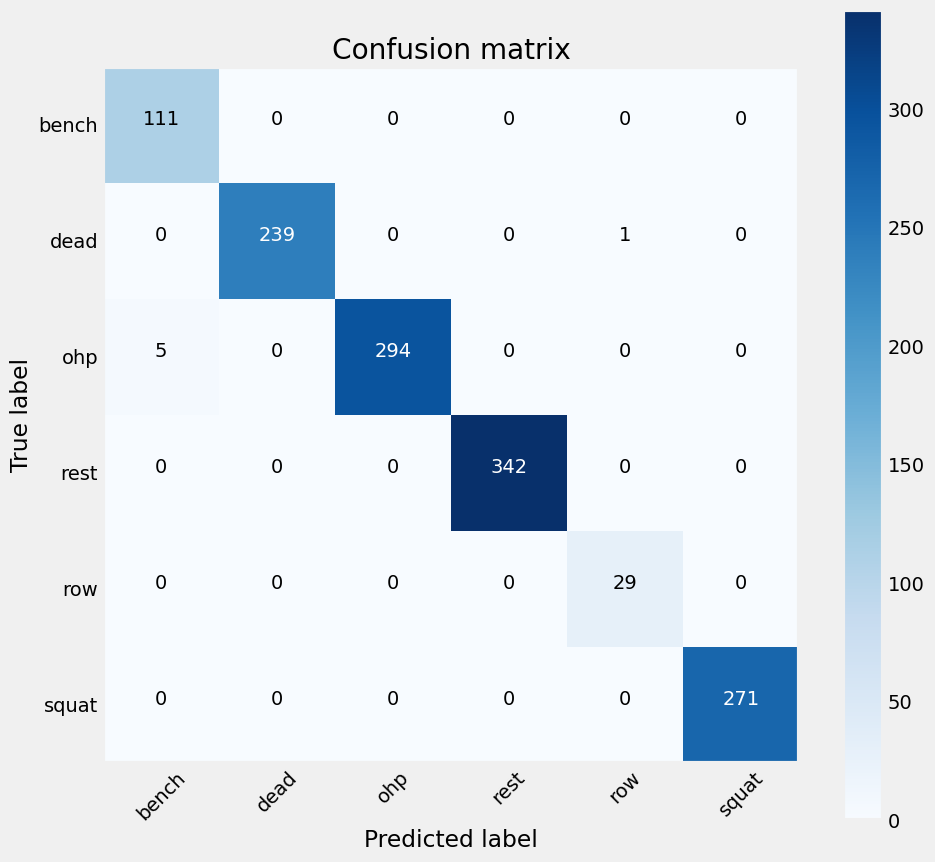

In [42]:
# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()